In [25]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
# Load nodes from a Pandas DataFrame
# Example DataFrame with columns X, Y, Z, Atom_Name, Residue_Name, Residue_ID, Atom_Type, and Timeframe
# Load nodes for all timesteps from a .npy file
filepath = '/home/mhanowar/Downloads/dataframe100frames.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)


In [27]:
# Define the conditions
conditions = (
    (df['Residue_Name'] == 'CSP') & df['Atom_Type'].isin(['n', 'h']),
    (df['Residue_Name'] == 'SFL') & df['Atom_Type'].isin(['o', 'os']),
    (df['Residue_Name'] == 'RFL') & df['Atom_Type'].isin(['o', 'os'])
)

# Combine conditions using logical OR
final_condition = conditions[0] | conditions[1] | conditions[2]

# Apply the combined condition to filter the DataFrame
df = df[final_condition].reset_index(drop=True)
df = df[df['Timeframe'] <= 10]
df


,X,Y,Z,Atom_Name,Residue_Name,Residue_ID,Atom_Type,Timeframe
0,11.649165,-2.592921,29.447174,N11,CSP,1,n,0
1,6.221285,1.314937,23.042118,N23,CSP,1,n,0
2,5.545125,-4.408506,21.934305,N35,CSP,1,n,0
3,9.018182,-1.111371,31.179316,N55,CSP,1,n,0
4,14.323432,4.476876,25.651325,N67,CSP,1,n,0
...,...,...,...,...,...,...,...,...
2591,36.004780,58.507214,64.397781,O2,SFL,12,o,10
2592,46.783340,21.616560,58.334023,O1,SFL,13,os,10
2593,47.708271,17.741901,59.243435,O2,SFL,13,o,10
2594,52.811508,40.601761,68.256386,O1,SFL,14,os,10


In [28]:
def extract_edges(nodes, distance_threshold):
    pairwise_distances = pdist(nodes)
    distance_matrix = squareform(pairwise_distances)
    edges_indices = np.where(distance_matrix < distance_threshold)
    edges = [(i, j) for i, j in zip(edges_indices[0], edges_indices[1]) if i < j]
    return edges

In [29]:
# Number of timesteps
# num_timesteps = df_nodes['Timeframe'].nunique()
num_timesteps = 2
# Distance threshold
distance_threshold = 10


In [30]:
# Create an empty list to store DataFrames
edge_info_list = []

# Initialize an empty DataFrame for the final result
columns = ['Edge_idx', 'Atom1_Type', 'Atom2_Type', 'Atom1_Name', 'Atom2_Name',
           'Molecule1', 'Molecule2', 'Edge_Dist', 'Edge_Type', 'Time']
edge_info = pd.DataFrame(columns=columns)

# Iterate over timesteps
for timestep in range(num_timesteps):
    # Get node information for the current timestep
    nodes_info = df[df['Timeframe'] == timestep][['Residue_ID',
                                                               'X', 'Y', 'Z', 'Atom_Type', 'Atom_Name']]

    # Get node coordinates, Residue_ID, Atom_Type, and Atom_Name
    nodes = nodes_info[['X', 'Y', 'Z']].values
    residue_ids = nodes_info['Residue_ID'].values
    atom_types = nodes_info['Atom_Type'].values
    atom_names = nodes_info['Atom_Name'].values

    # Extract edges based on the distance threshold
    edges = extract_edges(nodes, distance_threshold)

    # Create a DataFrame for the current timestep
    timestep_df = pd.DataFrame(columns=['Edge_idx', 'Atom1_Type', 'Atom2_Type',
                                        'Atom1_Name', 'Atom2_Name', 'Molecule1', 'Molecule2', 'Edge_Dist', 'Edge_Type', 'Time'])

    # Save edge information to the DataFrame
    for edge_num, edge in enumerate(edges):
        node1 = edge[0]
        node2 = edge[1]
        edge_distance = np.linalg.norm(nodes[node1] - nodes[node2])  # Euclidean distance

        molecule1 = residue_ids[node1]
        molecule2 = residue_ids[node2]

        # Update Edge_Type based on conditions
        if (1 <= molecule1 <= 4 and 5 <= molecule2 <= 14) or (1 <= molecule2 <= 4 and 5 <= molecule1 <= 14):
            edge_type = 0
        elif molecule1 == molecule2:
            edge_type = 1
        else:
            edge_type = 2

        # Save Atom_Type and Atom_Name as Node1 and Node2
        node1_atom_type = atom_types[node1]
        node2_atom_type = atom_types[node2]
        node1_atom_name = atom_names[node1]
        node2_atom_name = atom_names[node2]

        timestep_df = pd.concat([timestep_df, pd.DataFrame({
            'Edge_idx': [edge_num],
            'Atom1_Type': [node1_atom_type],
            'Atom2_Type': [node2_atom_type],
            'Atom1_Name': [node1_atom_name],
            'Atom2_Name': [node2_atom_name],
            'Molecule1': [molecule1],
            'Molecule2': [molecule2],
            'Edge_Dist': [round(edge_distance, 2)],
            'Edge_Type': [edge_type],
            'Time': [timestep]
        })], ignore_index=True)

    print(f'Timestep {timestep}: Number of Edges = {len(edges)}')

    # Append the DataFrame for the current timestep to the list
    edge_info_list.append(timestep_df)

# Concatenate the list of DataFrames into the final DataFrame
edge_info = pd.concat(edge_info_list, ignore_index=True)



/tmp/ipykernel_2622761/801908587.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  timestep_df = pd.concat([timestep_df, pd.DataFrame({


Timestep 0: Number of Edges = 922


/tmp/ipykernel_2622761/801908587.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  timestep_df = pd.concat([timestep_df, pd.DataFrame({


Timestep 1: Number of Edges = 933


In [31]:
edge_info

,Edge_idx,Atom1_Type,Atom2_Type,Atom1_Name,Atom2_Name,Molecule1,Molecule2,Edge_Dist,Edge_Type,Time
0,0,n,n,N11,N23,1,1,9.26,1,0
1,1,n,n,N11,N35,1,1,9.85,1,0
2,2,n,n,N11,N55,1,1,3.48,1,0
3,3,n,n,N11,N67,1,1,8.46,1,0
4,4,n,n,N11,N79,1,1,5.30,1,0
...,...,...,...,...,...,...,...,...,...,...
1850,928,os,o,O1,O2,10,10,4.08,1,1
1851,929,os,o,O1,O2,11,11,4.07,1,1
1852,930,os,o,O1,O2,12,12,4.08,1,1
1853,931,os,o,O1,O2,13,13,4.17,1,1


In [32]:
# Print the shape of the DataFrame
print("DataFrame Shape:", edge_info.shape)

filtered_edge_info = edge_info

DataFrame Shape: (1855, 10)


In [33]:
# Merge 'Node1' and 'Molecule1' into 'Node1' with a comma
filtered_edge_info['Node1'] = filtered_edge_info['Atom1_Type'].astype(str) + '_' + filtered_edge_info['Atom1_Name'].astype(str) + '_'+ filtered_edge_info['Molecule1'].astype(str)

# Merge 'Node2' and 'Molecule2' into 'Node2' with a comma
filtered_edge_info['Node2'] = filtered_edge_info['Atom2_Type'].astype(str) + '_' + filtered_edge_info['Atom2_Name'].astype(str) + '_'+ filtered_edge_info['Molecule2'].astype(str)

#filtered_edge_info = filtered_edge_info.drop(['Atom1_Type', 'Atom2_Type','Atom1_Name', 'Atom2_Name', 'Molecule1', 'Molecule2'], axis=1)
# Drop unnecessary columns if needed
filtered_edge_info = filtered_edge_info[['Time', 'Edge_idx', 'Node1', 'Node2', 'Edge_Dist', 'Edge_Type']]
# Print the modified DataFrame
print("Modified DataFrame Shape:", filtered_edge_info.shape)
print(filtered_edge_info)


Modified DataFrame Shape: (1855, 6)
     Time Edge_idx     Node1    Node2  Edge_Dist Edge_Type
0       0        0   n_N11_1  n_N23_1       9.26         1
1       0        1   n_N11_1  n_N35_1       9.85         1
2       0        2   n_N11_1  n_N55_1       3.48         1
3       0        3   n_N11_1  n_N67_1       8.46         1
4       0        4   n_N11_1  n_N79_1       5.30         1
...   ...      ...       ...      ...        ...       ...
1850    1      928  os_O1_10  o_O2_10       4.08         1
1851    1      929  os_O1_11  o_O2_11       4.07         1
1852    1      930  os_O1_12  o_O2_12       4.08         1
1853    1      931  os_O1_13  o_O2_13       4.17         1
1854    1      932  os_O1_14  o_O2_14       3.98         1

[1855 rows x 6 columns]


In [34]:
filtered_edge_info.to_csv('filtered_edge_info.csv', index=False)


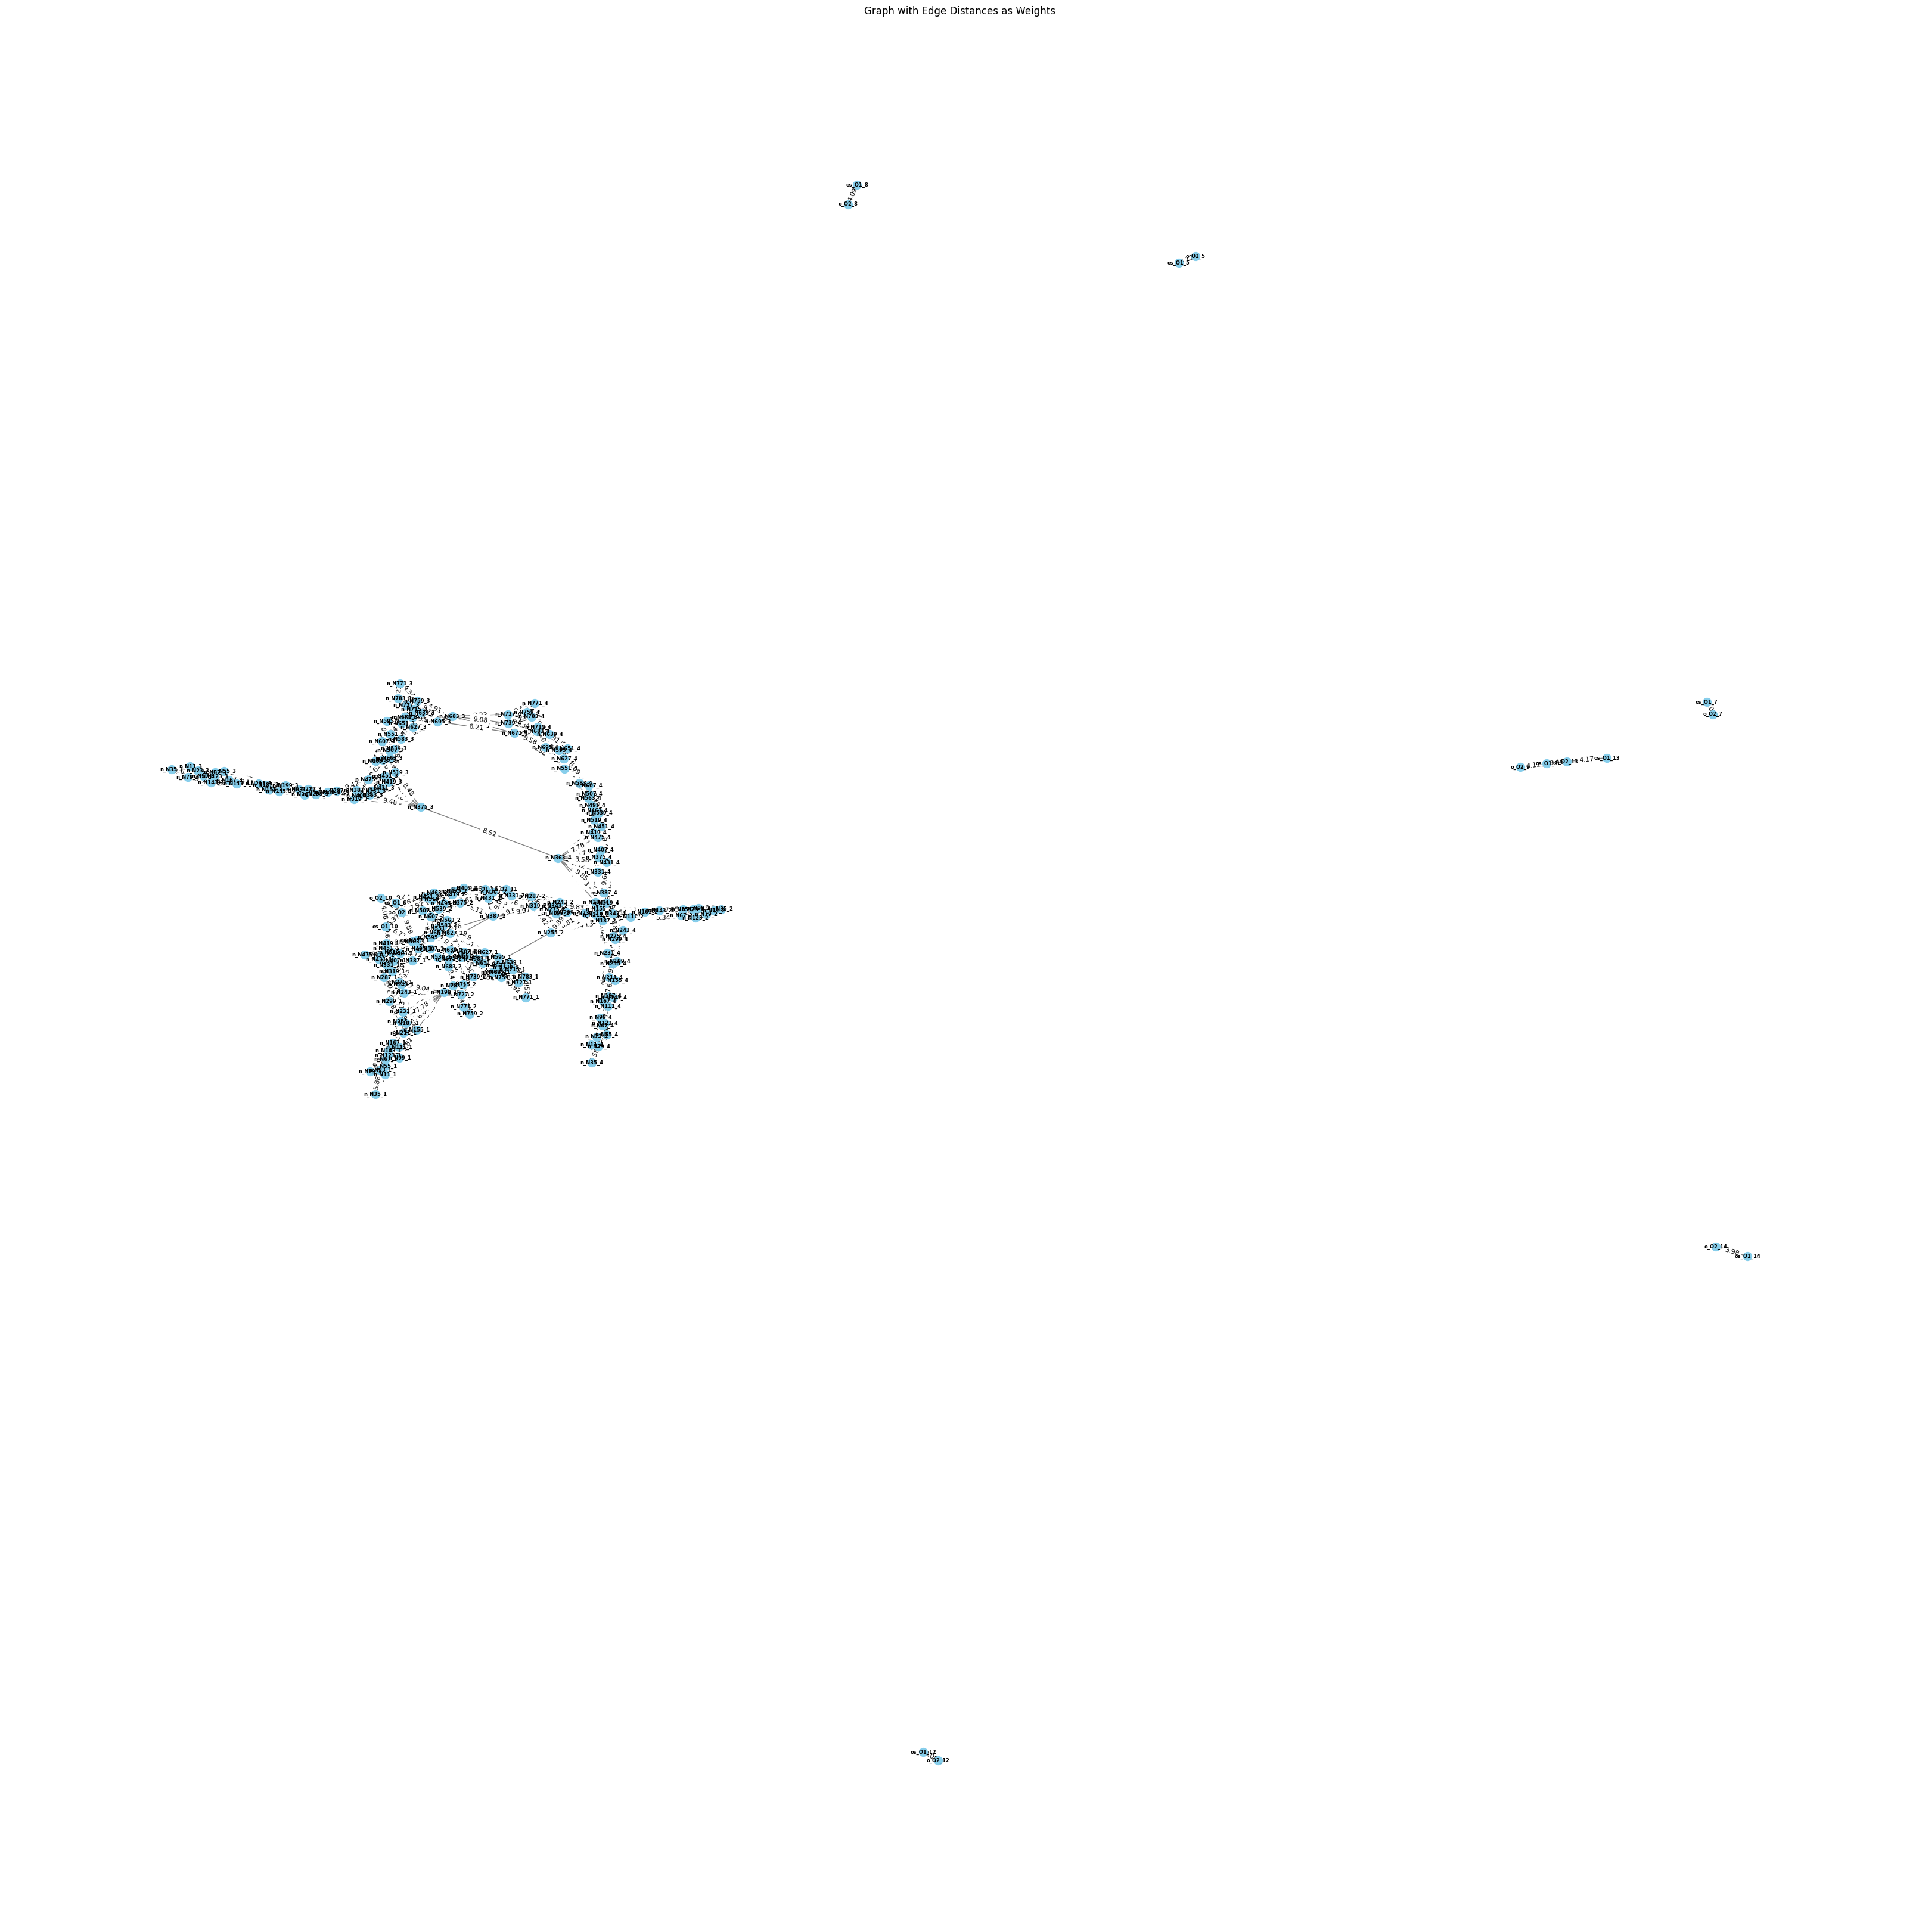

In [35]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

df = filtered_edge_info

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    G.add_node(row['Node1'])
    G.add_node(row['Node2'])
    G.add_edge(row['Node1'], row['Node2'], weight=row['Edge_Dist'])

# Draw the graph
pos = nx.spring_layout(G)  # You can use different layouts
edge_labels = {(row['Node1'], row['Node2']): round(row['Edge_Dist'], 2) for _, row in df.iterrows()}

plt.figure(figsize=(32,32))
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=100, node_color='skyblue', font_color='black', 
        font_size=6, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title('Graph with Edge Distances as Weights')
plt.show()


In [36]:
import pandas as pd

# Perform one-hot encoding for 'Node1' and 'Node2'
df_encoded = pd.get_dummies(filtered_edge_info, columns=['Node1', 'Node2'], drop_first=True)

# Print the encoded DataFrame
df_encoded


,Time,Edge_idx,Edge_Dist,Edge_Type,Node1_n_N111_2,Node1_n_N111_3,Node1_n_N111_4,Node1_n_N11_1,Node1_n_N11_2,Node1_n_N11_3,...,Node2_o_O2_13,Node2_o_O2_14,Node2_o_O2_5,Node2_o_O2_6,Node2_o_O2_7,Node2_o_O2_8,Node2_o_O2_9,Node2_os_O1_10,Node2_os_O1_11,Node2_os_O1_6
0,0,0,9.26,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,1,9.85,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,3.48,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3,8.46,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,4,5.30,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,1,928,4.08,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1851,1,929,4.07,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1852,1,930,4.08,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1853,1,931,4.17,1,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [37]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = filtered_edge_info

# Extract 'Node1' and 'Node2' columns
nodes_data = df[['Node1', 'Node2']]



# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform 'Node1' and 'Node2'
nodes_encoded = encoder.fit_transform(nodes_data)

# Create new column names for the one-hot encoded features
encoded_columns = encoder.get_feature_names_out(['Node1', 'Node2'])

# Replace the original 'Node1' and 'Node2' columns with the one-hot encoded features
df_encoded = pd.concat([df.drop(['Node1', 'Node2'], axis=1), pd.DataFrame(nodes_encoded, columns=encoded_columns)], axis=1)

# Print the encoded DataFrame
df_encoded


/home/mhanowar/Desktop/GNN_repos_server/Virtual_Environment/graphenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Time,Edge_idx,Edge_Dist,Edge_Type,Node1_n_N111_2,Node1_n_N111_3,Node1_n_N111_4,Node1_n_N11_1,Node1_n_N11_2,Node1_n_N11_3,...,Node2_o_O2_13,Node2_o_O2_14,Node2_o_O2_5,Node2_o_O2_6,Node2_o_O2_7,Node2_o_O2_8,Node2_o_O2_9,Node2_os_O1_10,Node2_os_O1_11,Node2_os_O1_6
0,0,0,9.26,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,9.85,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,3.48,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,8.46,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,5.30,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,1,928,4.08,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851,1,929,4.07,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852,1,930,4.08,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853,1,931,4.17,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
import torch

# Assuming 'filtered_edge_info' is a DataFrame with 'Edge_Type' column
edge_type = filtered_edge_info['Edge_Type'].values.astype(int)

# Edge type features using PyTorch
num_edge_types = len(set(edge_type))
print("Number of Edge Types:", num_edge_types)

# One-hot encode the edge types directly using PyTorch
edge_type_feats = torch.nn.functional.one_hot(torch.from_numpy(edge_type), num_classes=num_edge_types)

# Print the one-hot encoded features and their dimensions
print("One-Hot Encoded Features:")
print(edge_type_feats)
print("Feature Dimensions:", edge_type_feats.size(1))


Number of Edge Types: 3
One-Hot Encoded Features:
tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])
Feature Dimensions: 3


In [39]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame
# Numeric feature scaling
numeric_features = ['Edge_Dist']
df[numeric_features] = (df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std()

# Adding random noise to numeric features
numeric_noise = np.random.normal(0, 0.1, size=(len(df), len(numeric_features)))
df[numeric_features] += np.where(df[numeric_features].applymap(np.isreal), numeric_noise, 0)

# Label smoothing for categorical features (assuming 'Node1' and 'Node2' are categorical)
categorical_features = ['Node1', 'Node2']
df[categorical_features] = df[categorical_features].apply(lambda x: x.apply(lambda y: y + np.random.normal(0, 0.1) if isinstance(y, (int, float)) else y))

# Flipping labels for the target variable
df['Edge_Type'] = 1 - df['Edge_Type']

# Adding random noise to the target variable
df['Edge_Type'] += np.random.choice([-1, 0, 1], size=len(df))
df['Edge_Type'] = df['Edge_Type'].clip(0, 1)  # Ensure values are between 0 and 1

# Print the augmented DataFrame
print(df)


     Time Edge_idx     Node1    Node2  Edge_Dist Edge_Type
0       0        0   n_N11_1  n_N23_1   1.013964         0
1       0        1   n_N11_1  n_N35_1   1.474624         1
2       0        2   n_N11_1  n_N55_1  -2.333547         0
3       0        3   n_N11_1  n_N67_1   0.582845         1
4       0        4   n_N11_1  n_N79_1  -1.242183         0
...   ...      ...       ...      ...        ...       ...
1850    1      928  os_O1_10  o_O2_10  -1.969461         0
1851    1      929  os_O1_11  o_O2_11  -1.800829         1
1852    1      930  os_O1_12  o_O2_12  -1.969332         0
1853    1      931  os_O1_13  o_O2_13  -1.810746         0
1854    1      932  os_O1_14  o_O2_14  -2.062733         0

[1855 rows x 6 columns]


/tmp/ipykernel_2622761/78581602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] = (df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std()
/tmp/ipykernel_2622761/78581602.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_features] += np.where(df[numeric_features].applymap(np.isreal), numeric_noise, 0)
/tmp/ipykernel_2622761/78581602.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] +